In [1]:
import os, random, sys, socket, lpips, shutil, operator

# 시간 측정해보기

import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.distributed as dist
import torchvision
import torch.nn.functional as F

from torch.utils.data import DataLoader

from datasets_Imagenet_best_worst import Imagenet_best_worst
from datasets_ImageNet import ImageNet_dataset
# from datasets_WeightParam import WParam_dataset
# from datasets_openimages_v6 import Openimages_v6_dataset

from pytorch_msssim import ms_ssim as ms_ssim_func

from models.TCM import TCM
from models.FTIC import FrequencyAwareTransFormer
from models.ELIC import ELIC, model_config

from utils.optimizers import *
from utils.util import *


from torch.utils.data import Dataset
from torchvision import transforms
import os
import PIL.Image as Image
import json, random
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob

/home/jgryu/miniconda3/envs/nic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jgryu/miniconda3/envs/nic/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


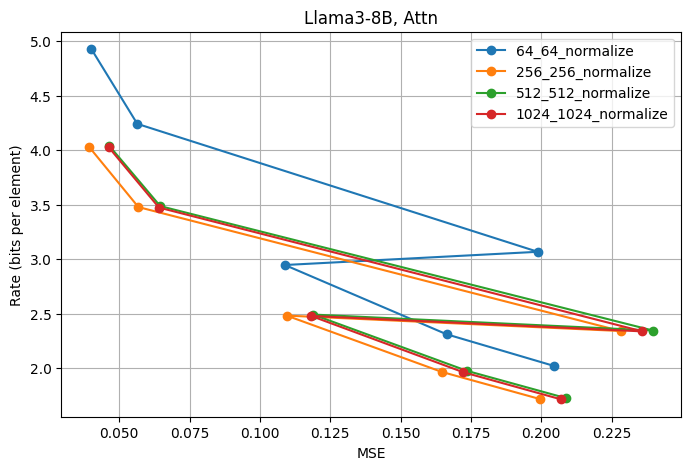

In [4]:
# result_dir = '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model_1/meta-llama-3-8b_attn_val_json'
result_dir = '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model/llama-2-7b_attn_train_json'
plt.figure(figsize=(8, 5))
for dim in [32, 64, 256, 512, 1024]:
    try:
        # json_file_path = os.path.join(result_dir, f'{dim}_{dim}', 'rd_data.json')
        # with open(json_file_path, 'r') as file:
        #     data = json.load(file)
        # plt.plot(data['mse'], data['bpp'], marker='o', linestyle='-', label=f'{dim}_{dim}')
        
        json_file_path = os.path.join(result_dir, f'{dim}_{dim}_normalize', 'data.json')
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        # # Plot the data
        plt.plot(data['mse'], data['bpp'], marker='o', linestyle='-', label=f'{dim}_{dim}_normalize')
        
        # json_file_path = os.path.join(result_dir, f'{dim}_{dim}_imagelize', 'rd_data.json')
        # with open(json_file_path, 'r') as file:
        #     data = json.load(file)
        # plt.plot(data['mse'], data['bpp'], marker='o', linestyle='-', label=f'{dim}_{dim}_imagelize')
        
    except:
        continue
    # # Add text annotations for each point
    # for idx, (mse, bpp) in enumerate(zip(data['mse'], data['bpp'])):
    #     plt.text(mse, bpp, str(idx), fontsize=8, ha='right', va='bottom')

plt.title('Llama3-8B, Attn')
plt.xlabel('MSE')
plt.ylabel('Rate (bits per element)')
plt.legend()
plt.grid(True)
plt.show()

# plt.figure(figsize=(8, 5))
# for dim in [32, 64, 256, 512, 1024]:
#     try:
#         json_file_path = os.path.join(result_dir, f'{dim}_{dim}_normalize', 'rd_data.json')
#         with open(json_file_path, 'r') as file:
#             data = json.load(file)

#         # Plot the data
#         plt.plot(data['mse'], data['bpp'], marker='o', linestyle='-', label=f'{dim}_{dim}')
        
#         # # Add text annotations for each point
#         # for idx, (mse, bpp) in enumerate(zip(data['mse'], data['bpp'])):
#         #     plt.text(mse, bpp, str(idx), fontsize=8, ha='right', va='bottom')
#     except :
#         continue
# plt.title('Rate vs. MSE (Val)')
# plt.xlabel('MSE')
# plt.ylabel('Rate (bits per element)')
# plt.legend()
# plt.grid(True)
# plt.show()

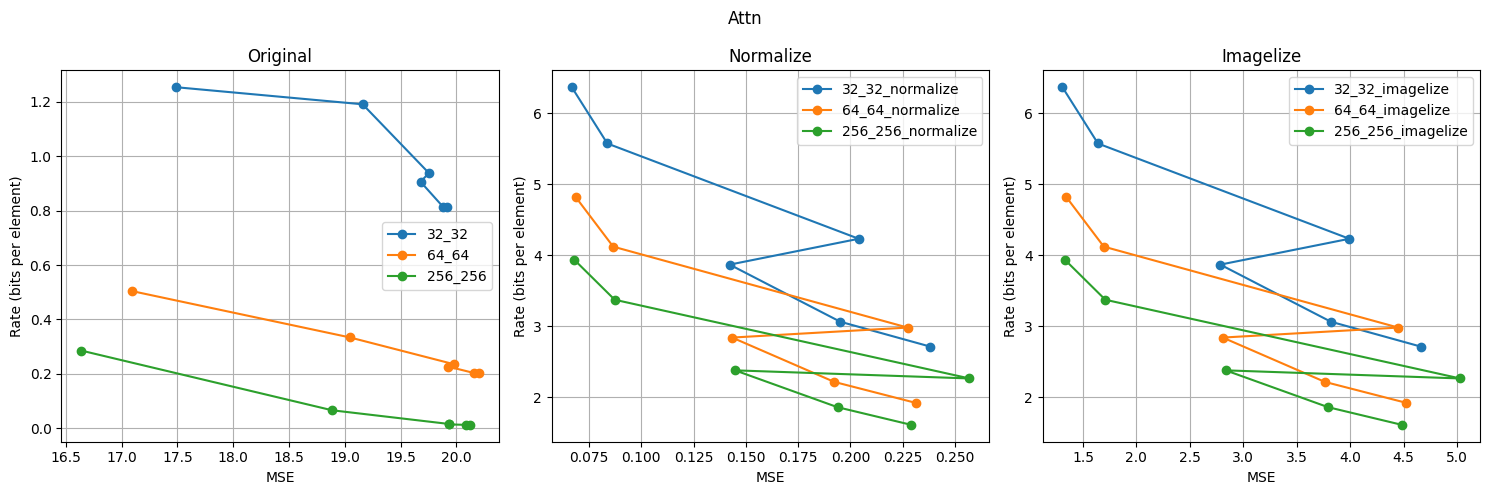

In [28]:
import os
import json
import matplotlib.pyplot as plt

result_dir = '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model_1/meta-llama-3-8b_attn_val_json'

# 서브플롯 설정
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Attn')
# 플롯 제목
titles = ['Original', 'Normalize', 'Imagelize']

# 각 데이터셋에 대해 서브플롯에 그림
for i, mode in enumerate(['', '_normalize', '_imagelize']):
    ax = axes[i]
    for dim in [32, 64, 256, 512, 1024]:
        try:
            json_file_path = os.path.join(result_dir, f'{dim}_{dim}{mode}', 'rd_data.json')
            with open(json_file_path, 'r') as file:
                data = json.load(file)
            ax.plot(data['mse'], data['bpp'], marker='o', linestyle='-', label=f'{dim}_{dim}{mode}')
        except FileNotFoundError:
            continue

    ax.set_title(titles[i])
    ax.set_xlabel('MSE')
    ax.set_ylabel('Rate (bits per element)')
    ax.legend()
    ax.grid(True)

# 전체 플롯 간 간격 조정
plt.tight_layout()
plt.show()


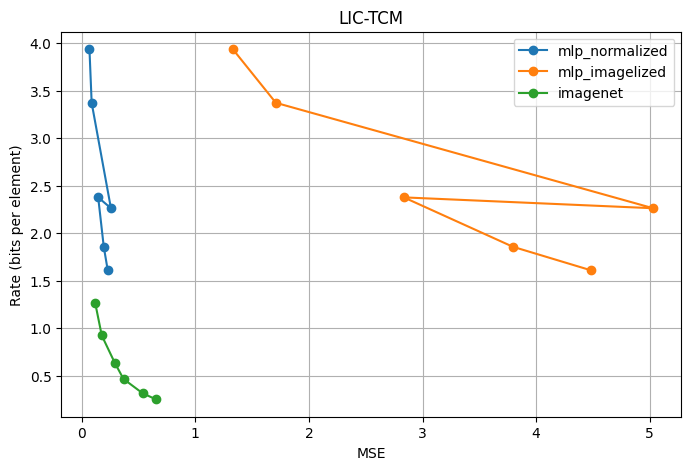

In [30]:

result_dir = '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model_1/meta-llama-3-8b_attn_val_json'
dirs = [('mlp_normalized', '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model_1/meta-llama-3-8b_attn_val_json/256_256_normalize'),
        ('mlp_imagelized', '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model_1/meta-llama-3-8b_attn_val_json/256_256_imagelize'),
        ('imagenet', '/home/jgryu/Weight_compression/nic_weight_comp/test_image_with_image_pt_model')
        ]
plt.figure(figsize=(8, 5))
for label, path in dirs:
    try:
        json_file_path = os.path.join(path, 'rd_data.json')
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        plt.plot(data['mse'], data['bpp'], marker='o', linestyle='-', label=label)
        
    except:
        continue
    # # Add text annotations for each point
    # for idx, (mse, bpp) in enumerate(zip(data['mse'], data['bpp'])):
    #     plt.text(mse, bpp, str(idx), fontsize=8, ha='right', va='bottom')

plt.title('LIC-TCM')
plt.xlabel('MSE')
plt.ylabel('Rate (bits per element)')
plt.legend()
plt.grid(True)
plt.show()

# plt.figure(figsize=(8, 5))
# for dim in [32, 64, 256, 512, 1024]:
#     try:
#         json_file_path = os.path.join(result_dir, f'{dim}_{dim}_normalize', 'rd_data.json')
#         with open(json_file_path, 'r') as file:
#             data = json.load(file)

#         # Plot the data
#         plt.plot(data['mse'], data['bpp'], marker='o', linestyle='-', label=f'{dim}_{dim}')
        
#         # # Add text annotations for each point
#         # for idx, (mse, bpp) in enumerate(zip(data['mse'], data['bpp'])):
#         #     plt.text(mse, bpp, str(idx), fontsize=8, ha='right', va='bottom')
#     except :
#         continue
# plt.title('Rate vs. MSE (Val)')
# plt.xlabel('MSE')
# plt.ylabel('Rate (bits per element)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [11]:
path = '/home/jgryu/Weight_compression/nic_weight_comp/checkpoints_image_pretrained'
pt_list = os.listdir(path)
print(pt_list)
lmbdas = []
for pt in pt_list:
    print(pt)
    lm = pt.replace('.pth', '')
    print(lm)
    lmbdas.append(float(lm))
lmbdas = sorted(lmbdas)
lmbdas

['0.013.pth', '0.0025.pth', '0.05.pth', '0.0035.pth', '0.025.pth', '0.0067.pth']
0.013.pth
0.013
0.0025.pth
0.0025
0.05.pth
0.05
0.0035.pth
0.0035
0.025.pth
0.025
0.0067.pth
0.0067


[0.0025, 0.0035, 0.0067, 0.013, 0.025, 0.05]

In [15]:
result_dir = '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model/meta-llama-3-8b_mlp_val_json'
for dim in [32, 64, 256, 512, 1024]:
    json_file_path = os.path.join(result_dir, f'{dim}_{dim}', 'data.json')
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    data['lmbda'] = [0.013, 0.0025, 0.0067, 0.05, 0.025, 0.0035]
    sorted_indices = sorted(range(len(data['lmbda'])), key=lambda i: data['lmbda'][i])
    rd_data = {
        'lmbda': [data['lmbda'][i] for i in sorted_indices],
        'mse': [data['mse'][i] for i in sorted_indices],
        'bpp': [data['bpp'][i] for i in sorted_indices]
    }

    with open(json_file_path.replace('data', 'rd_data'), 'w') as json_file:
        json.dump(rd_data, json_file, indent=4)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jgryu/Weight_compression/nic_weight_comp/test_wp_with_image_pt_model/meta-llama-3-8b_attn_val_json/512_512/data.json'